# Transformation Methods

In [179]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false)

## Inversion Method

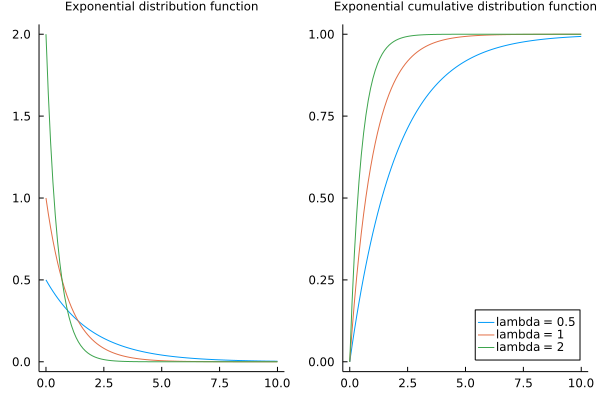

In [11]:
function f(x, lambda)
   lambda .* exp.(- lambda .* x)
end

function F(x, lambda)
    1 .- exp.(- lambda .* x)
end

x = [0:0.1:10;]

plot(x, f(x, 0.5), label="\\lambda = 0.5", 
    title="Exponential distribution function", 
    titlefontsize=8, layout=(1, 2), subplot=1, legend=false)
plot!(x, f(x, 1), label="\\lambda = 1", subplot = 1)
plot!(x, f(x, 2), label="\\lambda = 2", subplot = 1)

plot!(x, F(x, 0.5), label="\\lambda = 0.5", 
    title = "Exponential cumulative distribution function", 
    titlefontsize=8, subplot = 2, legend=:bottomright)
plot!(x, F(x, 1), label="\\lambda = 1", subplot = 2)
plot!(x, F(x, 2), label="\\lambda = 2", subplot = 2)

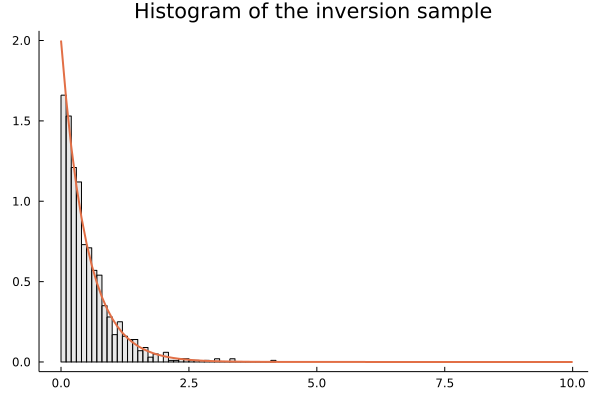

In [12]:
function inv_F(x, lambda)
    - log.(1 .- x) ./ lambda
end

function inv_exp_sample(;N=1000, lambda=1)
    u = rand(Uniform(), N)
    y = inv_F(u, lambda)
    y
end
lambda = 2
y = inv_exp_sample(lambda=lambda)
histogram(y, fillalpha=0.5, normed=true, title="Histogram of the inversion sample")
plot!(x, f(x, lambda), width=2)

## Box-Muller for Generating Normals

$X_1, X_2 \sim N(0,1)$ if:
$$X_1 = R \cdot \cos(\theta) \quad X_2 = R \cdot \sin(\theta)$$
Where $\theta \sim U[0, 2\pi]$ and $R^2 \sim Exp(1/2)$.

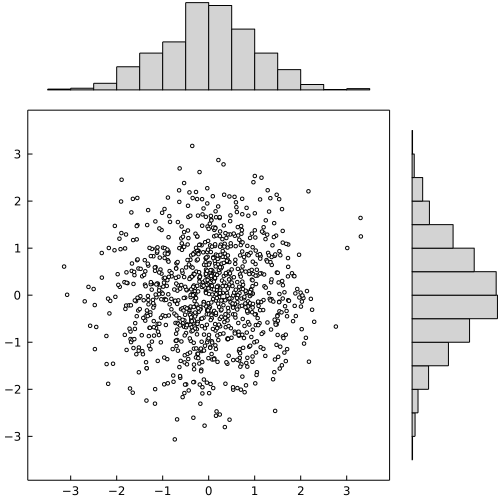

In [13]:
N = 1000
R = sqrt.(inv_exp_sample(N=N, lambda=0.5))
theta = rand(Uniform(), N) * 2 * pi

X1 = R .* cos.(theta)
X2 = R .* sin.(theta)

layout = @layout [a            _
                  b{0.8w,0.8h} c]

plot(layout=layout, link=:both, size=(500, 500), margin=-10Plots.px)
scatter!(X1, X2, subplot=2, framestyle=:box)
histogram!([X1 X2], subplot=[1 3], orientation=[:v :h], framestyle=:none)

## Rejection Sampling

### Sampling from Beta distribution with Uniform proposal

$$f(x) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}x^{a-1}(1-x)^{b-1}, \quad \text{for }0<x<1$$

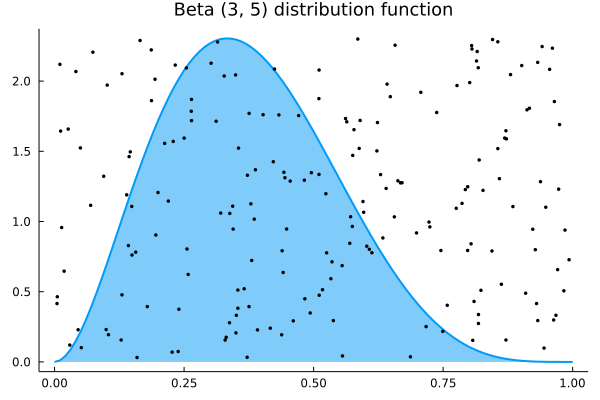

In [80]:
a = 3
b = 5
d = Beta(a,b)
x_M = (a - 1) / (a + b - 2)
M = pdf.(d, x_M)

x = [0:0.01:1;]
N = 200
X = rand(Uniform(), N)
Y = rand(Uniform(0, M), N) 
plot(x, pdf.(d,x), fillrange=[zeros(length(x)), pdf.(d,x)], fillcolor = 1, 
    fillalpha=0.5, title="Beta ($a, $b) distribution function", 
    width=2, titlefontsize=12)
scatter!(X, Y)

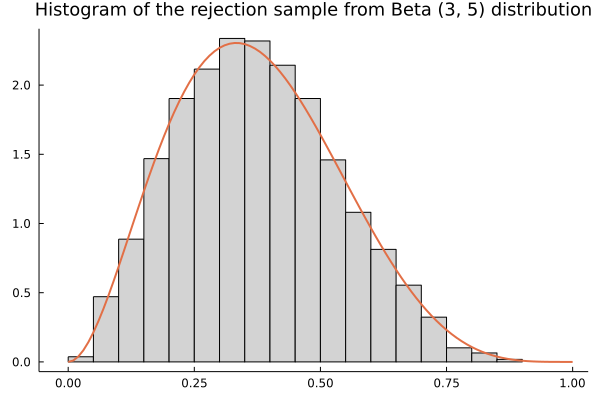

In [73]:
function rej_beta_sample(;a, b, N=1000)
    d = Beta(a,b)
    x_M = (a - 1) / (a + b - 2)
    M = pdf.(d, x_M)
    X = rand(Uniform(), N)
    Y = rand(Uniform(0, M), N)
    accept = Y .< pdf.(d, X)
    X[accept]
end

histogram(rej_beta_sample(N=5000, a=a, b=b), bins=30, normed=true)
plot!(x, pdf.(d,x), 
    title="Histogram of the rejection sample from Beta ($a, $b) distribution", 
    width=2, titlefontsize=12)

### Sampling from Normal with Cauchy proposal

Target distribution: Normal(0,1)
$$f(x) = \frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{x^2}{2}\right)}$$

Proposal distribution: Cauchy
$$g(x) = \frac{1}{\pi(1+x^2)}$$

Bounding constant s.t. $f(x) \leq Mg(x)$ is $M = \sqrt{2\pi}\exp{(-1/2)}$.

In [ ]:
dg = Cauchy()
df = Normal()
N = 200
X = rand(dg, N)

x = [-8:0.01:8;]
plot(x, M*pdf.(dg,x), width=2, fillrange=[zeros(length(x)) M*pdf.(df,x)], 
    fillalpha=0.5, label="Cauchy", legend=:topright)
plot!(x, pdf.(df,x), width=2, fillrange=[zeros(length(x)) pdf.(df,x)], 
    fillalpha=0.5, label="Normal(0,1)")

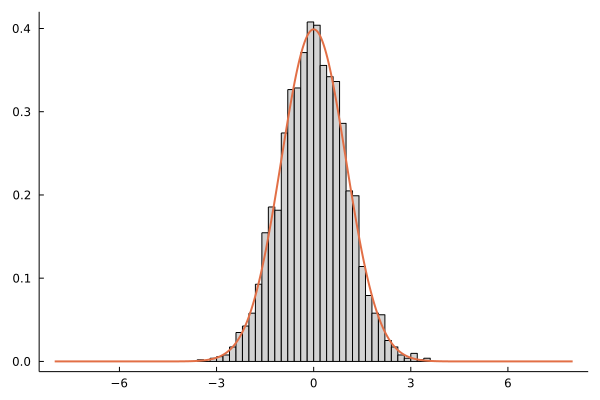

In [108]:
function rej_normal_sample(N=4000)
    M = sqrt(2 * pi) * exp(-0.5)
    dg = Cauchy()
    df = Normal()
    X = rand(dg, N)
    U = rand(Uniform(), N)
    prob = pdf.(df, X) ./ (M * pdf.(dg, X))
    accept = U .< prob
    X[accept]
end

X = rej_normal_sample()
histogram(X, normed=true)
plot!(x, pdf.(df,x), width=2, label="Normal(0,1)")

## Importance Sampling

Goal: find the estimate of $\mathbf{E}_f|X|$, where $X \sim t_3$ ($t$-distribution with 3 dergrees of freedom)

Proposal distributions:
1. $g_1(x) = t_3$
3. $g_2(x) = t_1$
2. $g_3(x) = N(0,1)$

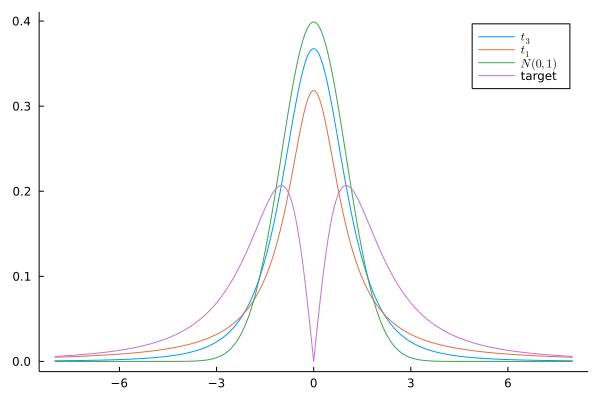

In [170]:
g1 = TDist(3)
g2 = TDist(1)
g3 = Normal()
df = TDist(3)

x = [-8:0.01:8;]
plot(x, [pdf.(g1, x), pdf.(g2, x), pdf.(g3,x), abs.(x) .* pdf.(df, x)], 
    label = [L"t_3" L"t_1" L"N(0,1)" "target"], legend=:topright)

In [287]:
function imp_sample(;g, N=1500)
    X = rand(g, N)
    W = pdf.(df, X) ./ pdf.(g, X)
    est  = cumsum(abs.(X) .* W )./ [1:1:N;]
    est
end

est_df = DataFrame(
    est1 = imp_sample(g=g1),
    est2 = imp_sample(g=g2),
    est3 = imp_sample(g=g3)
)

est_df[!, "max_est1"] = est_df[!, "est1"]
est_df[!, "max_est2"] = est_df[!, "est2"]
est_df[!, "max_est3"] = est_df[!, "est3"]

est_df[!, "min_est1"] = est_df[!, "est1"]
est_df[!, "min_est2"] = est_df[!, "est2"]
est_df[!, "min_est3"] = est_df[!, "est3"]

for i in range(1, 100)
    est1 = imp_sample(g=g1)
    est2 = imp_sample(g=g2)
    est3 = imp_sample(g=g3)
    
    est_df[!, "max_est1"] = max.(est_df[!, "max_est1"], est1)
    est_df[!, "max_est2"] = max.(est_df[!, "max_est2"], est2)
    est_df[!, "max_est3"] = max.(est_df[!, "max_est3"], est3)
    
    est_df[!, "min_est1"] = min.(est_df[!, "min_est1"], est1)
    est_df[!, "min_est2"] = min.(est_df[!, "min_est2"], est2)
    est_df[!, "min_est3"] = min.(est_df[!, "min_est3"], est3)
end

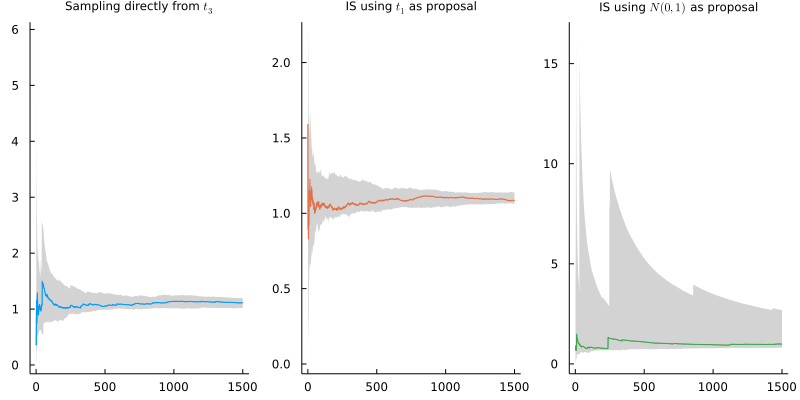

In [288]:
default(titlefontsize=8)
@df est_df plot([:est1 :est1], fillrange=[:min_est1 :max_est1], layout=(1,3),
    size = (800, 400), subplot=1, title="Sampling directly from "*L"t_3", color=1)
@df est_df plot!([:est2 :est2], fillrange=[:min_est2 :max_est2], subplot=2,
    title = "IS using "*L"t_1"*" as proposal", color=2)
@df est_df plot!([:est3 :est3], fillrange=[:min_est3 :max_est3], subplot=3,
    title = "IS using "*L"N(0,1)"*" as proposal", color=3)